<a href="https://colab.research.google.com/github/w-dan/MATM/blob/main/MATM-code/data-analysis/bert_no_other.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

This section includes installing required libraries and loading environment variables, also making sure GPUs are visible.

### Libraries

In [1]:
import importlib.util

def install_if_not_exists(package_name, no_deps=False):
    spec = importlib.util.find_spec(package_name)
    if spec is None:
        print(f"[+] Installing {package_name}...")
        if no_deps is False:
          !pip install {package_name} --quiet
        else:
          !pip install --no-deps {package_name} --quiet
    else:
        print(f"[-] {package_name} is already installed.")

In [2]:
# training
install_if_not_exists("torch", no_deps=False)
install_if_not_exists("transformers", no_deps=False)

# datasets
install_if_not_exists("datasets", no_deps=False)
install_if_not_exists("scikit-learn", no_deps=False)
install_if_not_exists("pandas", no_deps=False)
install_if_not_exists("pymongo", no_deps=False)

# other
install_if_not_exists("matplotlib", no_deps=False)
install_if_not_exists("python-dotenv", no_deps=False)

# wandb and deps
install_if_not_exists("sentry-sdk")
install_if_not_exists("setproctitle", no_deps=False)
install_if_not_exists("wandb", no_deps=False)
install_if_not_exists("click", no_deps=False)
install_if_not_exists("docker-pycreds", no_deps=False)

[-] torch is already installed.
[-] transformers is already installed.
[-] datasets is already installed.
[+] Installing scikit-learn...
[-] pandas is already installed.
[-] pymongo is already installed.
[-] matplotlib is already installed.
[+] Installing python-dotenv...
[+] Installing sentry-sdk...
[-] setproctitle is already installed.
[-] wandb is already installed.
[-] click is already installed.
[+] Installing docker-pycreds...


In [3]:
# core
import os, logging, time, torch, gc, re
from dotenv import load_dotenv

# dataset
from datasets import Dataset
from pymongo import MongoClient
import pandas as pd
from sklearn.model_selection import train_test_split

# training
import torch
from transformers import(
    EarlyStoppingCallback,
    AdamW,
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)


# evaluation
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from sklearn.metrics import accuracy_score
import seaborn as sns

In [4]:
if torch.cuda.is_available():
    print("CUDA is available. GPUs detected:")

    # available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # GPU info
    for i in range(num_gpus):
        print(f"\nGPU {i}:")
        print(f"  Name: {torch.cuda.get_device_name(i)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
        print(f"  Compute Capability: {torch.cuda.get_device_capability(i)}")
        print(f"  Current Memory Allocated: {torch.cuda.memory_allocated(i) / 1e6:.2f} MB")
        print(f"  Current Memory Cached: {torch.cuda.memory_reserved(i) / 1e6:.2f} MB")
else:
    print("CUDA is not available. No GPUs detected.")

CUDA is available. GPUs detected:
Number of available GPUs: 1

GPU 0:
  Name: NVIDIA TITAN V
  Total Memory: 12.64 GB
  Compute Capability: (7, 0)
  Current Memory Allocated: 0.00 MB
  Current Memory Cached: 0.00 MB


### Environment variables and constants

In [5]:
load_dotenv(".env")
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
TOKEN = os.getenv("HUGGINGFACE_TOKEN")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"

In [6]:
DATABASE_NAME = "APTs"

GPU check (Docker container will sometimes lose GPU visibility)

In [7]:
!nvidia-smi

Fri Jun 21 15:03:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN V                 Off | 00000000:5E:00.0 Off |                  N/A |
| 30%   44C    P8              26W / 250W |      4MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Dataset loading


Initially, we will be building a dataset with raw text and tools. The dataset is stored in a MongoDB database, so we will have to fetch the data:

In [8]:
collection_name = "blackberry"

In [9]:
client = MongoClient(CONNECTION_STRING)
db = client[DATABASE_NAME]

collection = db[collection_name]

In [10]:
documents = collection.find()

data = []
for doc in documents:

    clause = doc.get("clause", "")
    tactic = doc.get("tactic", "")

    data.append({
        "clause": clause,
        "tactic": tactic
    })

df = pd.DataFrame(data)

print(f"[+] Shape: {df.shape}")
df.head()

[+] Shape: (5000, 2)


,clause,tactic
0,!th 00000050: 69732070726f6772 616d2063616e6e6...,Execution
1,1 / 1 5www .prevailion.com /what-wicked-webs-w...,Initial Access
2,part ii: findings iia: naver -themed phishing ...,Initial Access
3,due ease operator create new subdomains hostin...,Initial Access
4,"accomplish this, lightshow drops legitimate ve...",Other


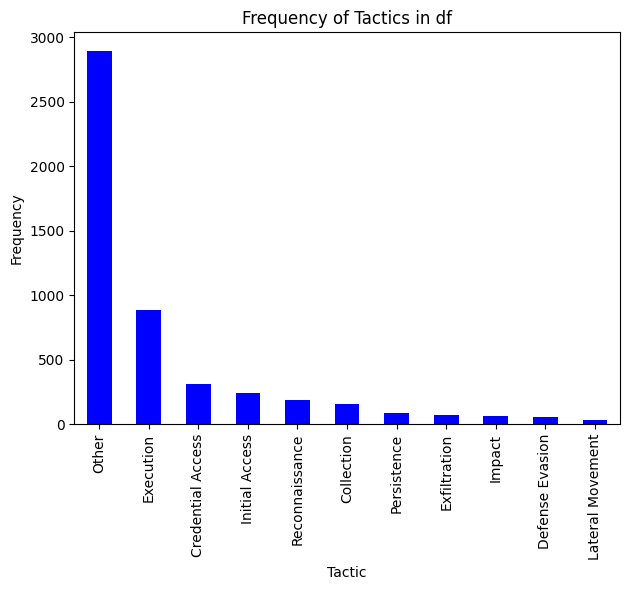

In [11]:
total_tactic_counts = df['tactic'].value_counts()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
total_tactic_counts.plot(kind='bar', color='blue')
plt.title('Frequency of Tactics in df')
plt.xlabel('Tactic')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

There is some clear bias towards `Execution` and `Other`. Even if these tags are the most common in a real-world scenario, it is convenient to downsample them due to the bias observed in experiment #7. The downsampling will be performed bearing in mind that the distribution of our data holds great importance, so they will still be more frequent in the dataset.

For this purpose, a maximum number of samples of 500 will be set.

In [12]:
from sklearn.utils import resample

tactic_counts = df['tactic'].value_counts()
print("[+] Original tactic counts:\n", tactic_counts)

max_samples = 500

# selecting rows to be downsampled
df_other = df[df['tactic'] == 'Other']
df_execution = df[df['tactic'] == 'Execution']

# downsampling
df_other_downsampled = resample(df_other, replace=False, n_samples=max_samples, random_state=42)
df_execution_downsampled = resample(df_execution, replace=False, n_samples=max_samples, random_state=42)

# rebuilding the dataframe
df_remaining = df[~df['tactic'].isin(['Other', 'Execution'])]
balanced_df = pd.concat([df_remaining, df_other_downsampled, df_execution_downsampled])


balanced_tactic_counts = balanced_df['tactic'].value_counts()
print("[+] Balanced tactic counts:\n", balanced_tactic_counts)

[+] Original tactic counts:
 tactic
Other                2895
Execution             884
Credential Access     310
Initial Access        244
Reconnaissance        188
Collection            155
Persistence            90
Exfiltration           75
Impact                 64
Defense Evasion        59
Lateral Movement       36
Name: count, dtype: int64
[+] Balanced tactic counts:
 tactic
Other                500
Execution            500
Credential Access    310
Initial Access       244
Reconnaissance       188
Collection           155
Persistence           90
Exfiltration          75
Impact                64
Defense Evasion       59
Lateral Movement      36
Name: count, dtype: int64


Removing `Other` tag

In [13]:
balanced_df = balanced_df[balanced_df['tactic'] != 'Other']

This should reduce the model's bias.

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch

In [15]:
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ["NCCL_SHM_DISABLE"] = "1"

# Dataset preparation

A custom dataset class `ClauseDataset` was created in order to be handled with data loaders (for Bert compatibility)

In [16]:
class ClauseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_df['clause'].tolist(), balanced_df['tactic'].tolist(), test_size=0.2, random_state=42)

In [19]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [20]:
label_dict = {label: idx for idx, label in enumerate(set(balanced_df['tactic']))}
train_labels = [label_dict[label] for label in train_labels]
val_labels = [label_dict[label] for label in val_labels]

In [23]:
label_dict

{'Persistence': 0,
 'Defense Evasion': 1,
 'Reconnaissance': 2,
 'Collection': 3,
 'Credential Access': 4,
 'Lateral Movement': 5,
 'Exfiltration': 6,
 'Initial Access': 7,
 'Impact': 8,
 'Execution': 9}

In [24]:
train_dataset = ClauseDataset(train_encodings, train_labels)
val_dataset = ClauseDataset(val_encodings, val_labels)

# Bert model and training

In [25]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_dict))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
training_args = TrainingArguments(
    output_dir='./results',          # result dir
    num_train_epochs=3,              # training epochs
    per_device_train_batch_size=8,   # train batch size
    per_device_eval_batch_size=8,    # eval batch size
    warmup_steps=500,                # warmup steps
    weight_decay=0.01,               # weight decay rate
    logging_dir='./logs',            # log directory
    logging_steps=10,
    eval_steps=10,
    eval_strategy='steps'
)

trainer = Trainer(
    model=model,                         # model to train
    args=training_args,                  # training args
    train_dataset=train_dataset,         # train dataset
    eval_dataset=val_dataset,            # test dataset
    data_collator=DataCollatorWithPadding(tokenizer),  # dynamic padding collator
)

In [27]:
training_logs = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: w-dan (seclab-etsisi). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
10,2.602300,2.477716
20,2.396600,2.357648
30,2.252400,2.218163
40,2.126600,2.191027
50,2.346600,2.177894
60,1.982600,2.158497
70,2.190900,2.121387
80,2.068500,2.083854
90,2.118000,2.066624
100,2.093900,2.036694


In [28]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.4502886235713959, 'eval_runtime': 3.4907, 'eval_samples_per_second': 98.834, 'eval_steps_per_second': 12.605, 'epoch': 3.0}


In [29]:
# @TODO: print functions

# Evaluation

In [30]:
label_dict_inverse = {v: k for k, v in label_dict.items()}  # Crear diccionario inverso

In [31]:
def predict(val_dataset):
    predictions = trainer.predict(val_dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    return pred_labels

def evaluate_predictions(true_labels, pred_labels, label_dict):
    true_label_names = [list(label_dict.keys())[list(label_dict.values()).index(label)] for label in true_labels]
    pred_label_names = [list(label_dict.keys())[list(label_dict.values()).index(label)] for label in pred_labels]

    print(classification_report(true_label_names, pred_label_names, target_names=list(label_dict.keys())))

    cm = confusion_matrix(true_label_names, pred_label_names, labels=list(label_dict.keys()))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_dict.keys()), yticklabels=list(label_dict.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [32]:
def clause_dataset_to_dataframe(clause_dataset, label_dict):
    """
    Converts ClauseDataset to a DataFrame.

    Parameters:
    clause_dataset (ClauseDataset): The ClauseDataset to convert.
    label_dict (dict): Dictionary mapping label indices to label names.

    Returns:
    pandas.DataFrame: DataFrame with clauses and labels.
    """
    labels = [label_dict[label] for label in clause_dataset.labels]
    df = pd.DataFrame({'labels': labels})
    return df

def plot_label_distribution_from_dataset(clause_dataset, label_dict):
    """
    Plots the distribution of labels in the ClauseDataset.

    Parameters:
    clause_dataset (ClauseDataset): The ClauseDataset containing the data.
    label_dict (dict): Dictionary mapping label indices to label names.

    Returns:
    None
    """
    df = clause_dataset_to_dataframe(clause_dataset, label_dict)
    label_counts = df['labels'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.xticks(rotation=45)
    plt.show()

In [33]:
label_dict

{'Persistence': 0,
 'Defense Evasion': 1,
 'Reconnaissance': 2,
 'Collection': 3,
 'Credential Access': 4,
 'Lateral Movement': 5,
 'Exfiltration': 6,
 'Initial Access': 7,
 'Impact': 8,
 'Execution': 9}

/tmp/ipykernel_4762/3654622633.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


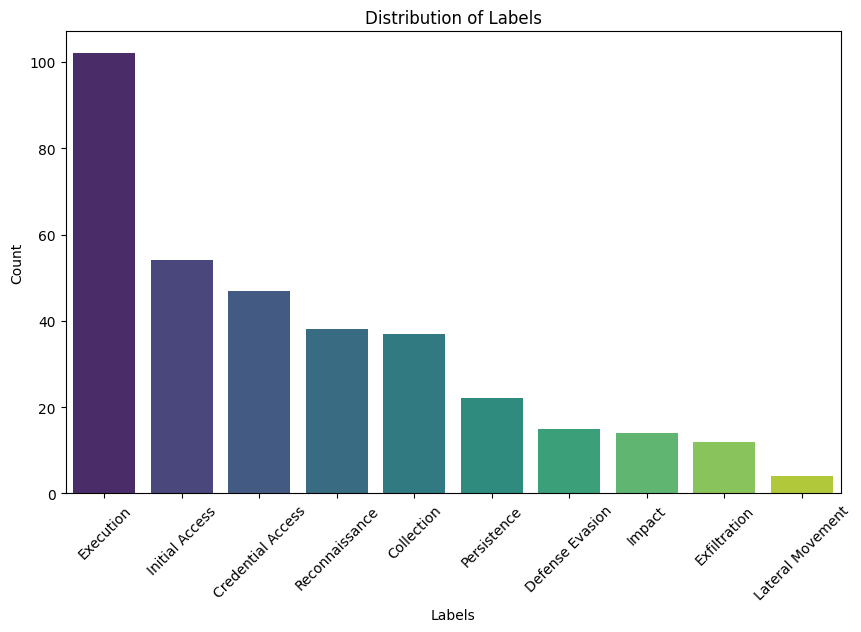

In [34]:
plot_label_distribution_from_dataset(val_dataset, {v: k for k, v in label_dict.items()})

In [35]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

                   precision    recall  f1-score   support

      Persistence       0.74      0.95      0.83        37
  Defense Evasion       0.98      0.98      0.98        47
   Reconnaissance       1.00      1.00      1.00        15
       Collection       0.96      0.92      0.94       102
Credential Access       0.91      0.83      0.87        12
 Lateral Movement       1.00      0.79      0.88        14
     Exfiltration       0.98      0.96      0.97        54
   Initial Access       1.00      0.50      0.67         4
           Impact       0.92      0.50      0.65        22
        Execution       0.65      0.84      0.74        38

         accuracy                           0.89       345
        macro avg       0.91      0.83      0.85       345
     weighted avg       0.91      0.89      0.89       345



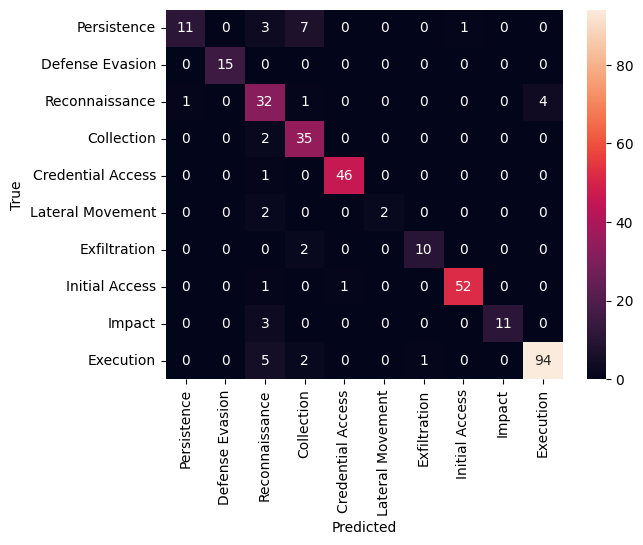

In [36]:
pred_labels = predict(val_dataset)
evaluate_predictions(val_labels, pred_labels, label_dict)

In [37]:
# val_dataset.labels
label_dict

{'Persistence': 0,
 'Defense Evasion': 1,
 'Reconnaissance': 2,
 'Collection': 3,
 'Credential Access': 4,
 'Lateral Movement': 5,
 'Exfiltration': 6,
 'Initial Access': 7,
 'Impact': 8,
 'Execution': 9}